# Collision Detection Notebook
Implementation of 3D Collision Detection Algorithms

********************************************************************************************

In [1]:
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [2]:
from primitives.triangle import Triangle
from scenes.scene import Scene
from scenes.render import render_scene
from utils.misc import get_floor

In [3]:
# #load object
#
# sphere_path = "objects/sphere.obj"
# cylinder_path = "objects/cylinder.obj"
# rabbit = "objects/rabbit.obj"
# carrot = "objects/carrot.obj"
# plane = "objects/plane.obj"
# squirrel = "objects/squirrel.obj"
# tree = "objects/broad_deciduous_tree_green_leaves.obj"
# ant = "objects/ant.obj"
# fireball = "objects/fireball.obj"
# dragon = "objects/dragon.obj"
#
#
# file_path = dragon
#
# path = Path(file_path).resolve()
# mesh = pv.read(path)
# mesh.plot()


/Users/dipanjan/anaconda3/envs/Primitive-Intersection/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


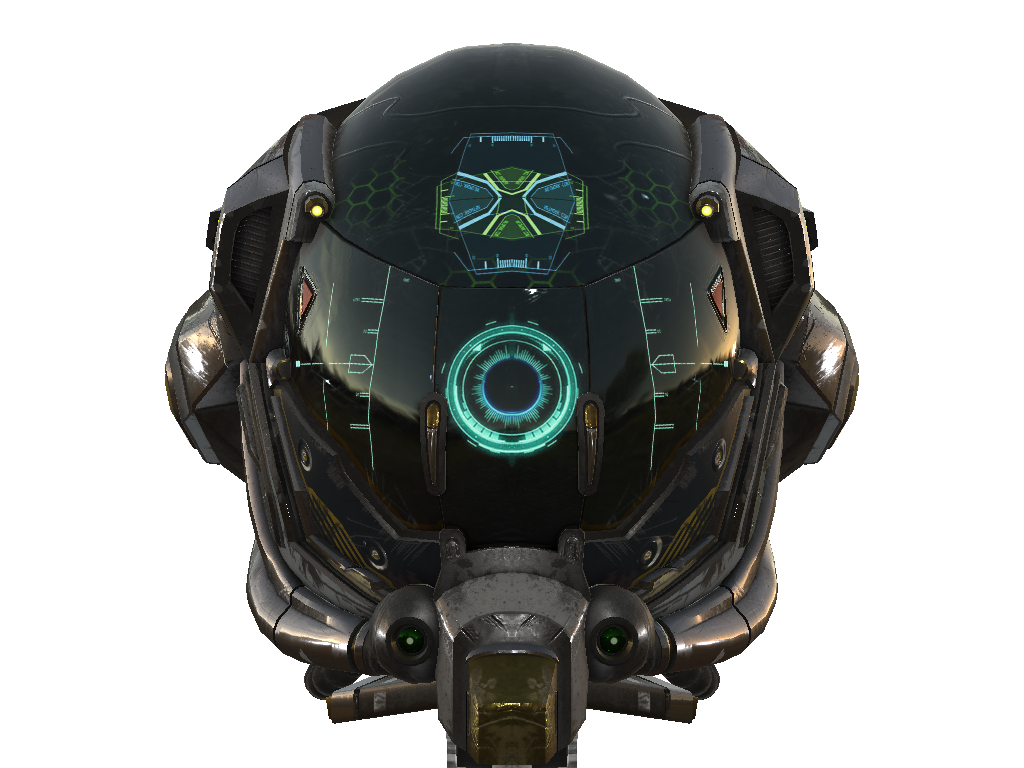

In [4]:
# Example: 15k primitives - helmet object


from pyvista import examples

helmet_file = examples.gltf.download_damaged_helmet()
texture = examples.download_dikhololo_night()

pl = pv.Plotter()
pl.import_gltf(helmet_file)
pl.set_environment_texture(texture)
pl.camera.zoom(1.7)
pl.show()

/Users/dipanjan/anaconda3/envs/Primitive-Intersection/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


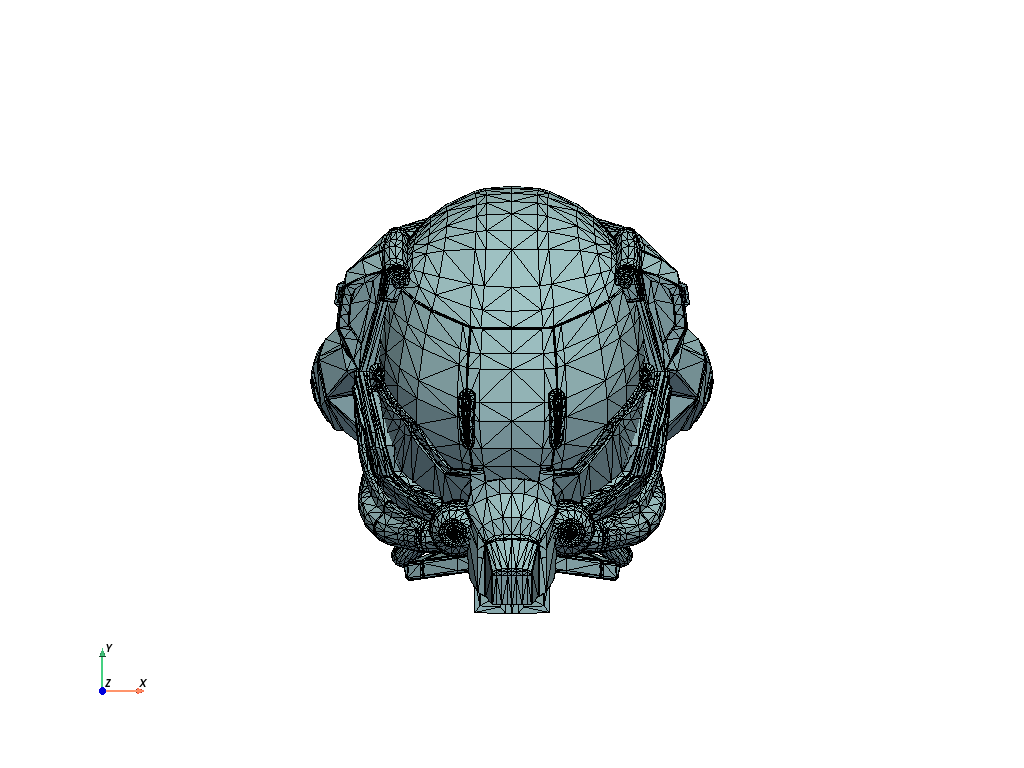

In [5]:
block = pv.read(helmet_file)
mesh = block[0][0][0]
mesh.plot(color='lightblue', show_edges=True, cpos='xy')

In [6]:
mesh = mesh.triangulate()
points = np.ascontiguousarray(mesh.points)
points

array([[-0.61199456, -0.48309004, -0.03094088],
       [-0.5795046 , -0.521758  ,  0.05627412],
       [-0.5735836 , -0.486858  ,  0.06353411],
       ...,
       [-0.0024817 ,  0.0679187 , -1.0864689 ],
       [ 0.64538044,  0.06791885, -0.7190059 ],
       [ 0.6460513 ,  0.04753773, -0.6916619 ]], dtype=float32)

In [7]:
points = np.ascontiguousarray(mesh.points)
faces = mesh.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)

In [8]:
# Initialise an empty list for primitives
objects = numba.typed.List()

In [9]:
# Add the triangles in the list of objects
for v in vertices:
    a,b,c = v[0], v[1], v[2]

    triangle = Triangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64))
    objects.append(triangle)

len(objects)

15452

In [10]:
from utils.vectors import normalize

# Calculate the bounding box of the point cloud
centroid = mesh.center

min_p = np.min(vertices)-5

centroid, min_p

([-0.0024815797805786133, 1.0520219802856445e-05, -0.18715494871139526],
 -6.18715500831604)

In [11]:
# Define the camera parameters based on the bounding box
camera = centroid + np.array([0.0, 0.0, min_p])  # Position behind the centroid
look_at = normalize(centroid - camera)  # Looking towards the centroid
camera, look_at

(array([-2.48157978e-03,  1.05202198e-05, -6.37430996e+00]),
 array([0., 0., 1.]))

In [12]:
# Setup scene

# screen
width=300
height=300


# Initialise the scene with lights and camera
scene = Scene(look_at=look_at, camera=camera, width=width, height=height)

In [13]:
from accelerators.bvh import BoundedBox

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = numba.typed.List()
for i in range(len(objects)):
    bounded_boxes.append(BoundedBox(objects[i], i))

len(objects), len(bounded_boxes)

(15452, 15452)

In [14]:
from accelerators.bvh import build_bvh

# Initialise a bounding volume hierarchy tree
start = 0
end = len(bounded_boxes)

ordered_prims = numba.typed.List()
ordered_prims.append(objects[0]) # just for numba
ordered_prims.pop(0)

total_nodes = numba.typed.List()
total_nodes.append(0)

split_method = 0 # 0: surface area heuristics, 1: mid-point, 2: equal parts

start_t = time.time()
root = build_bvh(objects, bounded_boxes, start, end, ordered_prims, total_nodes, split_method)

end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 3.2583558559417725


In [15]:
from accelerators.bvh import LinearBVHNode

# create a linear representation of the bvh tree (empty)

start_t = time.time()
linear_bvh = numba.typed.List()
for _ in range(total_nodes[0]):
    linear_bvh.append(LinearBVHNode())

end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

Elapsed (with compilation) = 0.3355562686920166


In [16]:
linear_bvh[0]

In [17]:
from accelerators.bvh import flatten_bvh

# add nodes to the empty linear tree
_offset = flatten_bvh(linear_bvh, root, [0])
len(linear_bvh), _offset

(30523, 0)

In [18]:
# # ** render function without progress bar **
#
# from scenes.render import _render_scene
#
# start_t = time.time()
# # primitives = spheres, triangles
# image = _render_scene(scene, objects, linear_bvh)
# end_t = time.time()
# print("Elapsed (with compilation) = %s" % (end_t - start_t))

In [19]:
from numba_progress import ProgressBar

num_iterations = scene.height

start_t = time.time()

with ProgressBar(total=num_iterations, ncols=80) as numba_progress1, ProgressBar(total=num_iterations, ncols=80) as numba_progress2:
    image = render_scene(scene, objects, linear_bvh, (numba_progress1, numba_progress2))

end_t = time.time()
print("Elapsed (with compilation) = %s" % (end_t - start_t))

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

/Users/dipanjan/PycharmProjects/Primitive-Intersection/scenes/render.py:27: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  nearest_object, min_distance, intersection, surface_normal = hit_object(primitives, bvh, ray)
/Users/dipanjan/PycharmProjects/Primitive-Intersection/scenes/render.py:27: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  nearest_object, min_distance, intersection, surface_normal = hit_object(primitives, bvh, ray)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Elapsed (with compilation) = 1.9133098125457764


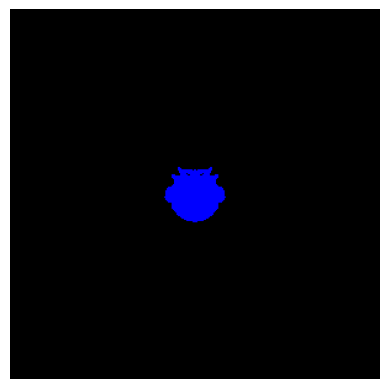

In [20]:
plt.imshow(image)
plt.axis('off')
plt.show()